# Working with SpECTRE data

In this tutorial we will look at the output data that SpECTRE simulations
produce and learn how to work with them in Python.

> Note that many of the functions we use here are also available on the command
> line, so you don't have to jump into Python to do quick plots. Explore what's
> available on the command line with `spectre --help`. We will point to specific
> subcommands below.

In [57]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rich
import rich.columns
from pathlib import Path
from spectre.Visualization.Plot import DEFAULT_MPL_STYLESHEET

plt.style.use(DEFAULT_MPL_STYLESHEET)

Here's some sample data from a complete BBH inspiral that we will be working
with in this tutorial (though you can also use your own data of course):

In [25]:
segment_dir = Path("/oscar/data/icerm/knelli/workshop_materials/01_monday/bbh_inspiral")

## Working with reduction data

Reduction data is collected from the simulation as a whole and written to a
single H5 file with multiple subfiles. For example, the L2 norm over all grid
points of a quantity would be written as reduction data:

In [34]:
reductions_file = segment_dir / "BbhReductions.h5"
with h5py.File(reductions_file) as open_reductions_file:
    rich.print(rich.columns.Columns(open_reductions_file.keys()))

ApparentHorizons   ConstraintEnergy.dat   ControlSystems                       Norms.dat                           
ObservationAhA.dat ObservationAhA_Ylm.dat ObservationAhB.dat                   ObservationAhB_Ylm.dat              
ObservationAhC.dat ObservationAhC_Ylm.dat ObservationExcisionBoundaryA_Ylm.dat ObservationExcisionBoundaryB_Ylm.dat
TimeSteps.dat      src.tar.gz

The data is written in simple matrix form with a legend, so a `pandas.DataFrame`
is the great representation of this data. The `to_dataframe` function simply
reads the legend and returns a DataFrame with named columns:

In [54]:
from spectre.Visualization.ReadH5 import to_dataframe

In [59]:
with h5py.File(reductions_file) as open_reductions_file:
    subfile = open_reductions_file["Norms.dat"]
    legend = subfile.attrs["Legend"]
    norms = pd.DataFrame(subfile, columns=legend)
    # This function does the above in one line:
    norms = to_dataframe(open_reductions_file["Norms.dat"])
norms

,Time,NumberOfPoints,Volume,L2Norm(Lapse),L2Norm(PointwiseL2Norm(GaugeConstraint)),L2Norm(PointwiseL2Norm(ThreeIndexConstraint))
0,0.00,739280.0,9.047787e+08,0.921331,1.615814e-16,1.184314e-18
1,0.10,739280.0,9.047787e+08,0.926950,7.146727e-07,4.427718e-06
2,0.20,739280.0,9.047787e+08,0.932036,4.128454e-07,6.723918e-06
3,0.30,739280.0,9.047787e+08,0.936589,7.360980e-07,1.190161e-05
4,0.40,739280.0,9.047787e+08,0.940652,5.617430e-07,8.926249e-06
...,...,...,...,...,...,...
51379,5129.53,739280.0,8.909280e+08,0.777121,1.787369e-03,7.236547e-02
51380,5129.54,739280.0,8.909280e+08,0.777009,1.812856e-03,7.334703e-02
51381,5129.55,739280.0,8.909280e+08,0.776896,1.839323e-03,7.428839e-02
51382,5129.56,739280.0,8.909279e+08,0.776782,1.866700e-03,7.517760e-02


### Example: Constraint norms

The data we read above can easily be plotted. It shows the evolution of the
generalized-harmonic constraints throughout the inspiral.

> **On the command line:** Try `spectre plot dat --help`.

<Axes: xlabel='Time'>

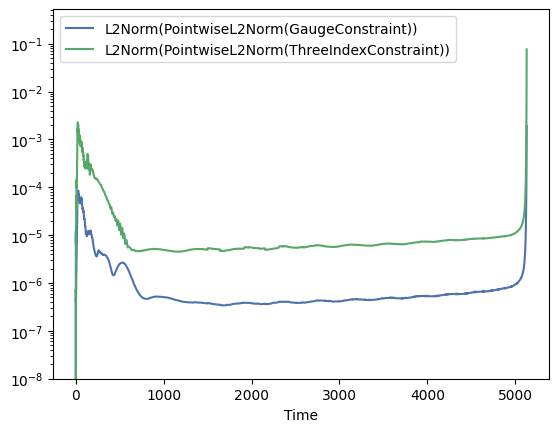

In [68]:
norm_labels = [label for label in norms.columns if "Constraint" in label]
norms.plot(x="Time", y=norm_labels, logy=True, ylim=(1e-8, None))

### Example: Horizon quantities

Here's the evolution of the primary black hole's mass throughout the inspiral:

In [64]:
with h5py.File(reductions_file) as open_reductions_file:
    AhA = to_dataframe(open_reductions_file["ObservationAhA.dat"])

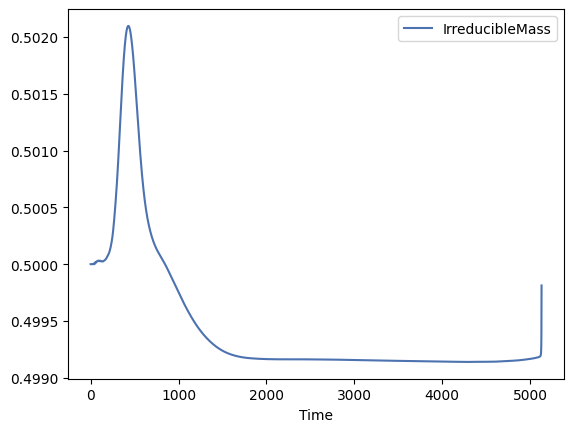

In [93]:
AhA.plot(x="Time", y="IrreducibleMass");

### Example: Trajectories

Here's the trajectory of the two black holes:

> **On the command line:** Try `spectre plot trajectories --help`.

In [69]:
with h5py.File(reductions_file) as open_reductions_file:
    AhA_coords = to_dataframe(
        open_reductions_file["ApparentHorizons/ControlSystemAhA_Centers.dat"]
    )
    AhB_coords = to_dataframe(
        open_reductions_file["ApparentHorizons/ControlSystemAhB_Centers.dat"]
    )

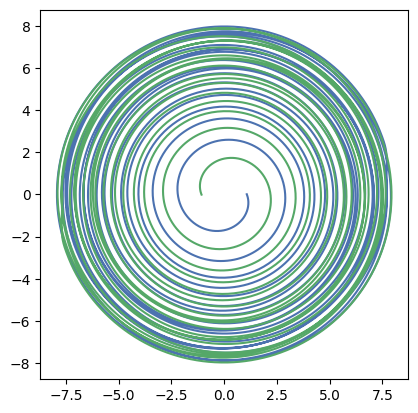

In [70]:
plt.plot(AhA_coords["InertialCenter_x"], AhA_coords["InertialCenter_y"])
plt.plot(AhB_coords["InertialCenter_x"], AhB_coords["InertialCenter_y"])
plt.gca().set_aspect("equal")

### Example: Time steps

To give you a taste of our asynchronous simulations in SpECTRE, let's look at
the time steps.

In [71]:
with h5py.File(reductions_file) as open_reductions_file:
    time_steps = to_dataframe(open_reductions_file["TimeSteps.dat"])
time_steps

,Time,NumberOfPoints,Slab size,Minimum time step,Maximum time step,Effective time step,Minimum Walltime,Maximum Walltime
0,0.00,739280.0,0.10,0.000195,0.000195,0.000195,11.789526,13.334739
1,0.10,739280.0,0.10,0.000049,0.006250,0.000445,194.301504,194.973257
2,0.20,739280.0,0.10,0.000098,0.006250,0.000494,492.783288,493.333352
3,0.30,739280.0,0.10,0.000024,0.012500,0.000295,725.543518,726.360118
4,0.40,739280.0,0.10,0.000024,0.012500,0.000479,980.721780,981.578449
...,...,...,...,...,...,...,...,...
51379,5129.53,739280.0,0.01,0.000020,0.005000,0.000261,139151.869243,139184.016300
51380,5129.54,739280.0,0.01,0.000039,0.005000,0.000266,139218.644924,139220.116807
51381,5129.55,739280.0,0.01,0.000020,0.005000,0.000118,139220.204581,139254.143663
51382,5129.56,739280.0,0.01,0.000020,0.005000,0.000197,139285.173362,139290.342383


First, let's look at the minimum and maximum time step throughout the inspiral.
We are using local time stepping, so some elements take smaller time steps than
others. The time step data is recorded at "slabs", which are time step
boundaries that all elements share:

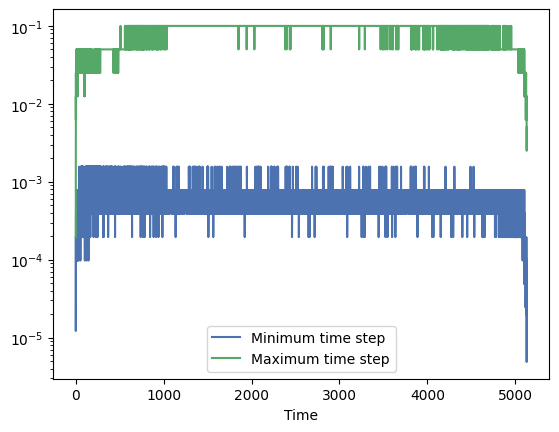

In [81]:
time_steps.plot(x="Time", y=["Minimum time step", "Maximum time step"], logy=True);

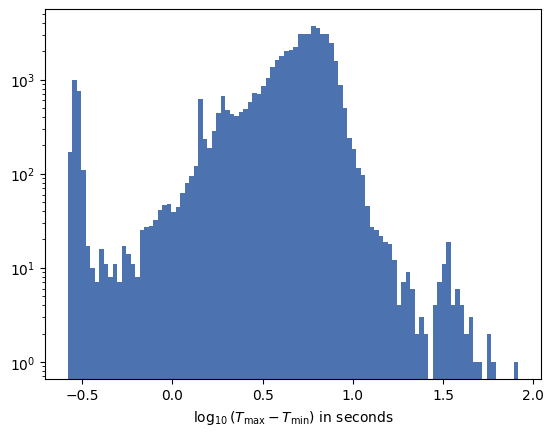

In [91]:
walltime_diff = time_steps["Maximum Walltime"] - time_steps["Minimum Walltime"]
plt.hist(np.log10(walltime_diff), bins=100)
plt.yscale("log")
plt.xlabel("$\log_{10}(T_\mathrm{max} - T_\mathrm{min})$ in seconds");

So, apparently, for most slabs in this run the first and last element to
complete the slab did so within 10 seconds of each other, but for some slabs
this spread was almost 100 seconds! Note that this doesn't mean the slab took
this long to complete, just that the different elements did so asynchronously at
different walltimes while their respective compute core was busy doing other
work.

> To learn more about our asynchronous task-based parallelism you will have to
> wait until Thursday.

## Working with 3D volume data

Volume data is 3D tensor data on all grid points of the computational domain.
This can be a lot of data (40GB for the sample inspiral data that we are looking
at here, which is at relatively low resolution), so we only write it sparingly,
and often only in single-precision floating point format. However, it can be
very valuable to understand issues with your simulations, and of course enables
you to create full 3D visualizations of your simulations. Also, volume data can
be used to start and restart simulations, so e.g. initial data is written in
this form.

SpECTRE simulations write one H5 volume data file per node, which is why you
will find multiple volume data files labeled with consecutive integers in your
output directory.

Here, we will look at volume data interactively in ParaView, we will make quick
3D renderings using the CLI, and we will load the data in Python to make 2D
plots. On Friday we will look closer at initial data and how to interpolate
volume data to different grids (and possibly different codes).

## Interactive 3D visualization with ParaView

To look at our simulation interactively in ParaView, we first have to generate
an XDMF file that references the data in the H5 volume data files so that
ParaView understand them. This is easiest done on the command line (though it's
also available in Python):

```sh
spectre generate-xdmf $BBH_DATA/BbhVolume*.h5 -d VolumeData -o Bbh.xmf
```

Now you can open this `Bbh.xmf` file in ParaView and play around with it to your
heart's content. For example, try the following:

- Create a slice or clip through the domain to see its interior.
- Switch to "Surface with Edges" to see the grid lines.
- Look at different quantities, such as the lapse or shift.

## Quick 3D renderings with the CLI

On the command line you can do quick renderings of your volume data with the
commands in the `spectre render-3d` subcommand. For example, try this to
visualize the domain structure:

```sh
spectre render-3d domain Bbh.xmf -o domain.png --zoom 20 --slice
```

![BBH domain](images/domain.png)

## Plot slices in Python

You can also load the volume data in Python and interpolate to any set of
points. This allows you to do slice plots, e.g. for papers.

> **On the command line:** Try `spectre plot {along-line|slice} --help` to do
> quick 1D or 2D plots of your volume data.

In [95]:
import glob
from spectre.IO.Exporter import interpolate_to_points
from spectre.Visualization.OpenVolfiles import open_volfiles
from spectre.Visualization.ReadH5 import list_observations

First, we collect all volume data files and the observations that they contain.
Each observation is identified by an _observation ID_, which is essentially a
hash of its time step:

In [103]:
volfiles = glob.glob(str(segment_dir / "BbhVolume*.h5"))
obs_ids, obs_times = list_observations(
    open_volfiles(volfiles, subfile_name="VolumeData")
)

Now we can interpolate the volume data to a rectangular grid for plotting:

In [104]:
# Coordinates of a rectangular grid in the xy plane
x, y = np.meshgrid(np.linspace(-15, 15, 300), np.linspace(-15, 15, 300))
z = np.zeros(x.shape)

lapse = np.array(
    interpolate_to_points(
        volfiles,
        subfile_name="VolumeData",
        observation_id=obs_ids[0],
        tensor_components=["Lapse"],
        target_points=[x.flatten(), y.flatten(), z.flatten()],
    )[0]
).reshape(x.shape)

/tmp/ipykernel_407384/1772273897.py:2: RuntimeWarning: invalid value encountered in subtract
  plt.contourf(x, y, np.log(1 - lapse))


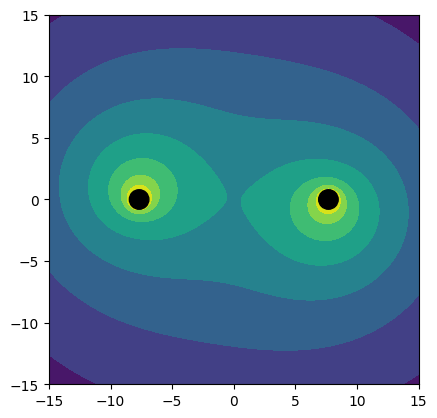

In [105]:
# Plot lapse
plt.contourf(x, y, np.log(1 - lapse))

# Plot circles for black holes (note that excisions are not always circles)
ax = plt.gca()
for bh_pos in [-7.683, 7.683]:
    ax.add_patch(
        plt.Circle(xy=(bh_pos, 0), radius=0.791616184028402, color="black", fill=True)
    )

# Make plot square
ax.set_aspect("equal")

## Plot individual elements

You can also iterate over elements in your volume data to plot things like
element boundaries, collocation points, etc. Use `iter_elements`:

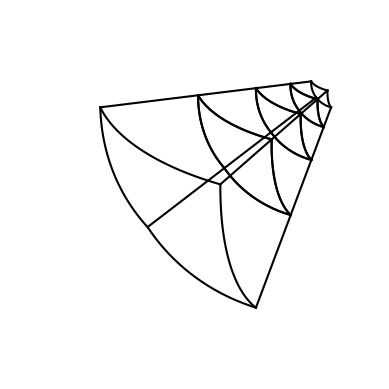

In [128]:
from spectre.IO.H5.IterElements import iter_elements

# Create a 3D plot
ax = plt.gcf().add_subplot(111, projection="3d")
ax.axis("off")

# Iterate over elements
for element in iter_elements(
    open_volfiles(volfiles, subfile_name="VolumeData"),
    obs_ids=obs_ids[0],
    element_patterns=["B3,(L1I0,L1I0,*)"],  # Only plot radial elements in block 3
):
    # Draw outline of the element by mapping the edges of the logical cube to
    # inertial coordinates using the element map
    for d in range(3):
        for edge in range(4):
            line = np.zeros((3, 100))
            line[d, :] = np.linspace(-1, 1, 100)
            line[(d + 1) % 3, :] = 2 * (edge % 2) - 1
            line[(d + 2) % 3, :] = 2 * (edge // 2) - 1
            x, y, z = element.map(line, element.time, element.functions_of_time)
            ax.plot(x, y, z, color="black")

# Make plot square
ax.set_aspect("equal")

### Power monitors

Power monitors are a powerful (😎) tool to analyze how well your domain resolves
your data. They are essentially the spectral coefficients of your data in each
element of the domain, marginalized over each logical dimension.

> You will learn more about power monitors tomorrow!

Power monitors are very easy to plot from the command line, so give it a try:

```sh
spectre plot power-monitors $BBH_DATA/BbhVolume*.h5 -d VolumeData -y Lapse \
  -b ObjectAShell -b ObjectACube -b Envelope -b OuterShell \
  --time 1000 -o power_monitors.pdf
```

![power monitors](images/power_monitors.png)

Here you see the power monitors of the lapse function at time 1000M in the
sample BBH data. Each curve corresponds to an element, and each panel shows a
different region of the domain (see the grid visualization above). Spectral
coefficients in the radial direction are red, and in the two angular directions
are blue and green.

This plot seems to tell us that at this time in the evolution, the accuracy of
the simulation is limited by the resolution in the cubes surrounding the black
holes. We could increase the polynomial order of the spectral expansion in these
elements to increase accuracy, or reduce the polynomial order in the inner
shell, envelope, and outer shell to save computational cost. This would be the
job of our adaptive mesh-refinement (AMR) algorithm, which you will also learn
more about tomorrow.

### Transforming volume data

Often you want to post-process volume data to compute derived quantities from
the ones the simulation has written out. You can sometime do this within tools
like ParaView (e.g. using ParaView's "Calculator" filter) if the computation is
simple enough and pointwise (i.e., needs no derivatives or other mesh
information). If you can't get what you need in ParaView, you can use `spectre
transform-vol`. It takes any Python function (a "kernel"), runs it over your
volume data, and writes the result back into the files.

To try this, copy one of the sample data files first:

```sh
cp $BBH_DATA/BbhVolume0.h5 ./
```

Now let's compute an estimate of the relative truncation error in each element,
which uses the power monitors that we looked at above:

```sh
spectre transform-vol BbhVolume0.h5 -d VolumeData \
    -k spectre.NumericalAlgorithms.LinearOperators.relative_truncation_error
```

You will be prompted to select a dataset name for the `tensor_component`
argument of the `relative_truncation_error` function (type in "Lapse") and for
the output data set name (hit enter to select the default
"RelativeTruncationError"). The result of the computation will be written back
into the H5 files. If you now regenerate an XDMF file for the volume data you
will be able to see the output of this function in ParaView.

You can also write your own kernels in Python. Create a Python file, e.g.
`kernel.py`, and write a function like this:

In [133]:
%%file kernel.py
from spectre.DataStructures.Tensor import Scalar, DataVector

def lapse_squared(lapse: Scalar[DataVector]) -> Scalar[DataVector]:
    return np.array(lapse)**2

Overwriting kernel.py


Now you can run this kernel over your volume data like this:

```sh
spectre transform-vol BbhVolume0.h5 -d VolumeData -e kernel.py -k lapse_squared
```